In [48]:
# %pip install scikit-learn pandas numpy matplotlib

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

classification = 'Mol Subtype'

data_path = "Final Pipeline/Data/"
filename = data_path + "MAX_384_110.csv"
feature_file = data_path + "MAX_features.csv"
patient_colname = 'PatientID'

TOP_K = 20

data = pd.read_csv(filename)
# remove unneeded columns
if 'sequence' in data.columns:
    data.pop('sequence')

In [50]:
labels = pd.read_csv("../Data/Patient class labels.csv")[['Patient ID', classification]]
labels = labels.rename(columns = {classification: 'class'})

In [51]:
features_with_labels = (pd.merge(data,
                                labels,
                                left_on = patient_colname,
                                right_on = 'Patient ID',
                                how = 'inner')
                        ).drop(columns = ['Patient ID',patient_colname])

y = features_with_labels.pop('class')
x = features_with_labels

## Feature Importance

### RF

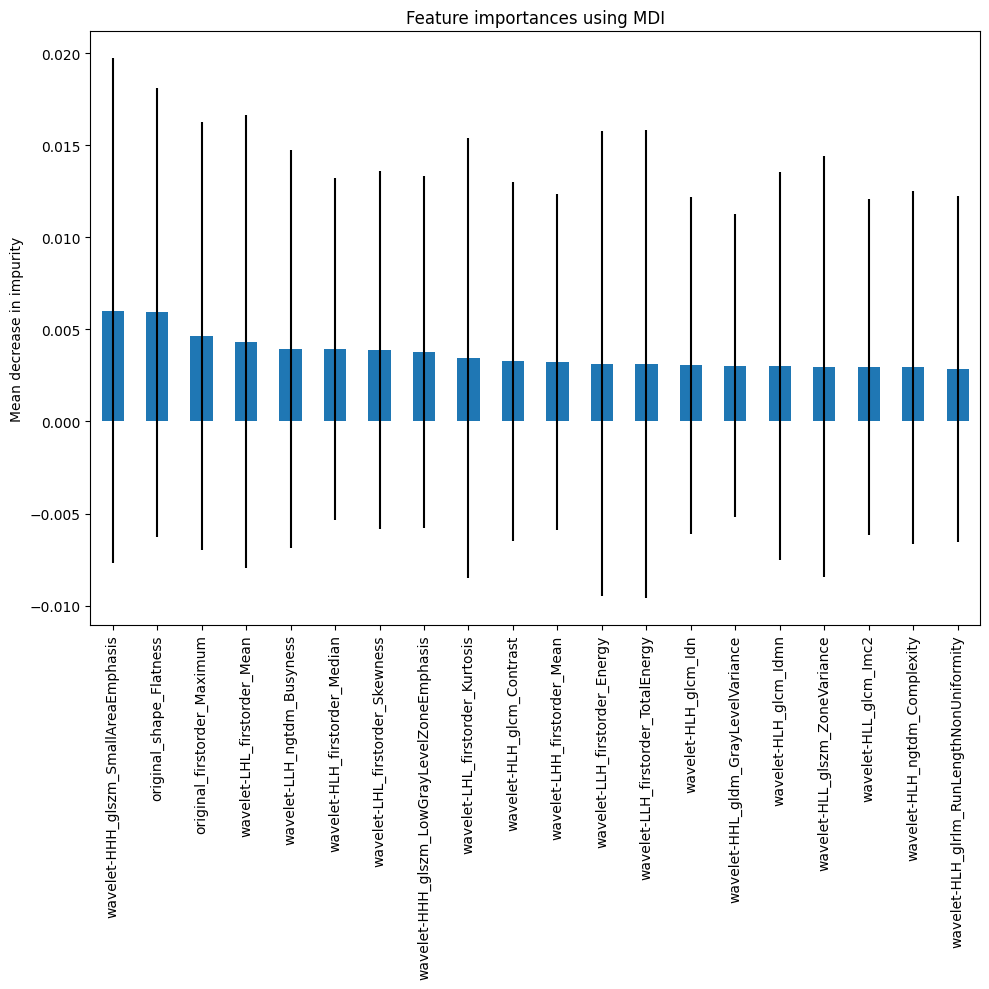

In [52]:
from sklearn.ensemble import RandomForestClassifier

# use random forests for feature importances
rf_cls = RandomForestClassifier().fit(x, y)
feat_imp_rf = rf_cls.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_cls.estimators_], axis=0)
feature_names = rf_cls.feature_names_in_
std = dict(zip(feature_names, std))

forest_importances = (
                        pd.Series(feat_imp_rf,
                                  index=feature_names)
                      ).sort_values(ascending = False)[:TOP_K]
top_feats = forest_importances.index
std = [std[feat] for feat in top_feats]

fig, ax = plt.subplots(figsize = (10, 10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from math import ceil

logreg = LogisticRegression().fit(StandardScaler().fit_transform(x), y)

c:\ProgramData\Anaconda3\envs\mri_project\envs\breast_mri_3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


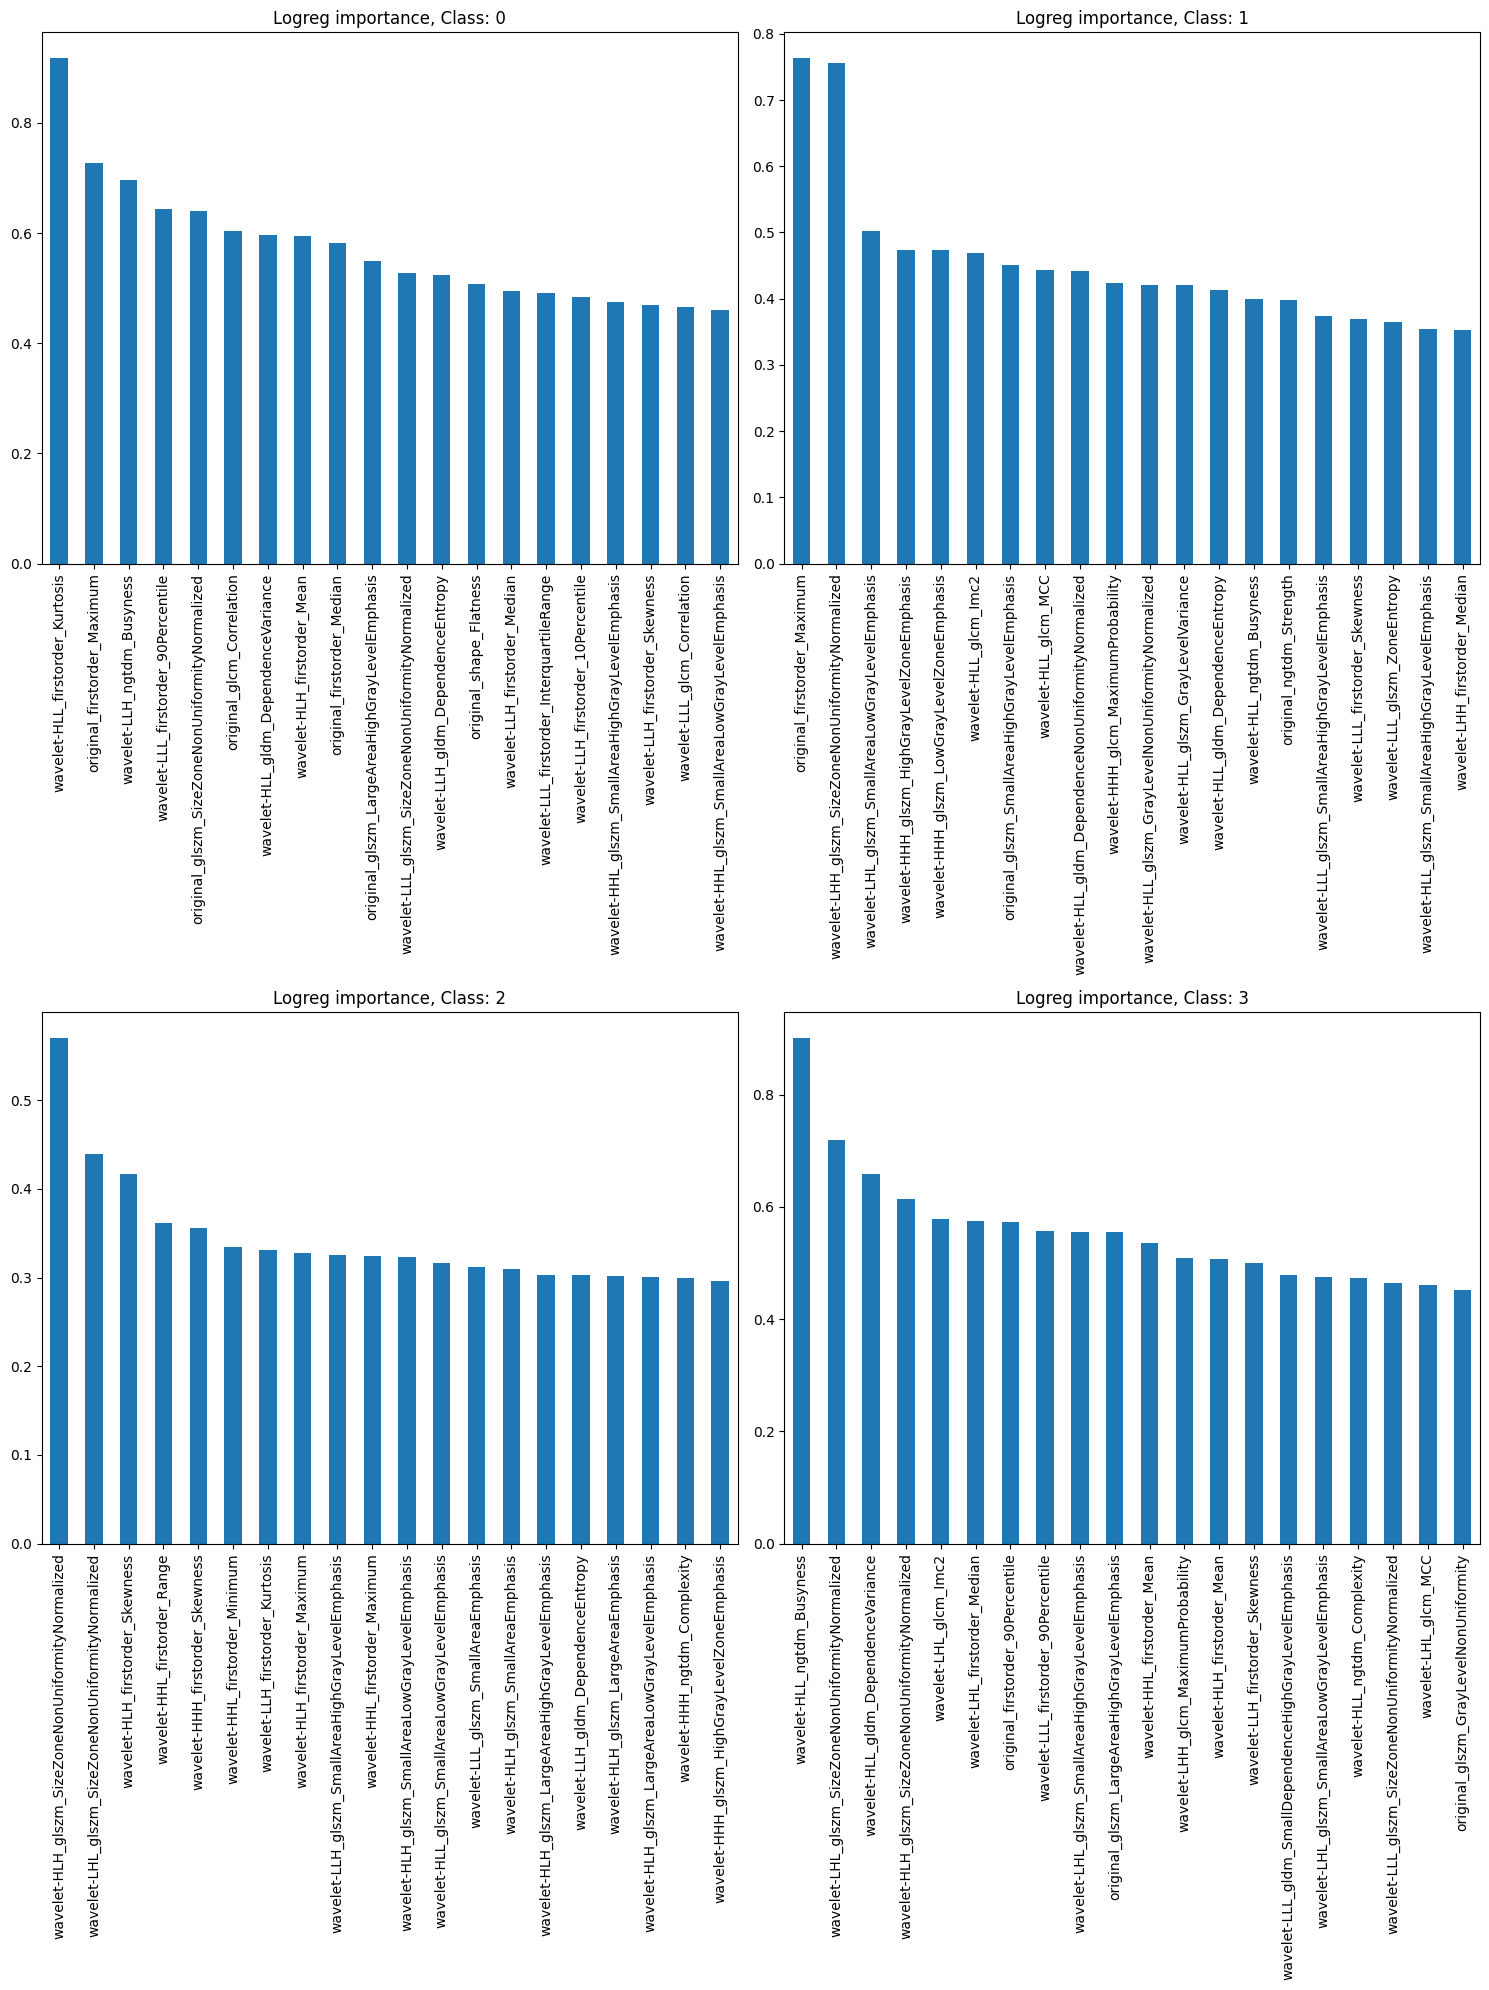

In [87]:
n_classes = len(y.unique())

feat_imp_lr = np.abs(logreg.coef_)
feature_names = x.columns


n_rows = n_classes//2
n_cols = ceil(n_classes/n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 20))
cls_idx = 0                 # to indicate which class to plot
for ax in axes.flatten():
    logreg_imp = (
                pd.Series(feat_imp_lr[cls_idx],
                          index=feature_names)
             ).sort_values(ascending = False)[:TOP_K]
    logreg_imp.plot.bar(ax=ax)
    ax.set_title(f"Logreg importance, Class: {cls_idx}")
    cls_idx+=1
fig.tight_layout()